# GCC's ssc-cdi : tomography pipeline for Cateretê v0.6.36
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/

## Imports

In [1]:
import tomopy

In [2]:
tomopy.prep.alignment.align_joint

<function tomopy.prep.alignment.align_joint(prj, ang, fdir='.', iters=10, pad=(0, 0), blur=True, center=None, algorithm='sirt', upsample_factor=10, rin=0.5, rout=0.8, save=False, debug=True)>

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import json
import sscCdi
import sscRaft

import os, sys, time, ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imsave
from functools import partial
from concurrent.futures import ProcessPoolExecutor

import sscRaft, sscRadon

from sscCdi.misc import save_json_logfile, create_directory_if_doesnt_exist, save_json_logfile_tomo, open_or_create_h5_dataset
from sscCdi.processing.unwrap import remove_phase_gradient, unwrap_in_parallel


print(f'sscCdi version: {sscCdi.__version__}')
print(f'sscRaft version: {sscRaft.__version__}')

plt.rcParams['image.cmap'] = 'cividis'

sscCdi version: 0.6.39
sscRaft version: 2.2.0


In [4]:
def define_paths(dic):
    """ Defines all the path required for the remaining parts of the code; adds them to the dicitionary and creates necessary folders

    Args:
        dic (dict): dictionary of inputs  
            keys:
                "sinogram_path": sinogram path
                "contrast_type": contrast type
                "output_folder": path for output files

    Returns:
        dic (dict): updated dictionary of inputs  
            updated keys:
                "filename"
                "temp_folder"
                "ordered_angles_filepath"
                "projected_angles_filepath"
                "ordered_object_filepath"
                "cropped_sinogram_filepath"
                "pre_aligned_sinogram_filepath"
                "equalized_sinogram_filepath"
                "unwrapped_sinogram_filepath"
                "wiggle_sinogram_filepath"
                "wiggle_cmas_filepath"
                "reconstruction_filepath"
                "eq_reconstruction_filepath"
    """

    dic["output_folder"] = dic["sinogram_path"].rsplit('/',1)[0]
    dic["filename"]    = os.path.join(dic["sinogram_path"].rsplit('/',1)[1].split('.')[0]+'_'+dic["contrast_type"])
    dic["temp_folder"] = os.path.join(dic["output_folder"],'temp')
    dic["ordered_angles_filepath"]       = os.path.join(dic["temp_folder"],f'{dic["filename"]}_ordered_angles.npy')
    dic["projected_angles_filepath"]     = os.path.join(dic["temp_folder"],f'{dic["filename"]}_ordered_angles_projected.npy')
    dic["ordered_object_filepath"]       = os.path.join(dic["temp_folder"],f'{dic["filename"]}_ordered_object.npy')
    dic["cropped_sinogram_filepath"]     = os.path.join(dic["temp_folder"],f'{dic["filename"]}_cropped_sinogram.npy')
    dic["pre_aligned_sinogram_filepath"] = os.path.join(dic["temp_folder"],f'{dic["filename"]}_prealigned_sinogram.npy')
    dic["equalized_sinogram_filepath"]   = os.path.join(dic["temp_folder"],f'{dic["filename"]}_equalized_sinogram.npy')
    dic["unwrapped_sinogram_filepath"]   = os.path.join(dic["temp_folder"],f'{dic["filename"]}_unwrapped_sinogram.npy')
    dic["wiggle_sinogram_filepath"]      = os.path.join(dic["temp_folder"],f'{dic["filename"]}_wiggle_sinogram.npy')
    dic["wiggle_cmas_filepath"]          = os.path.join(dic["temp_folder"],f'{dic["filename"]}_wiggle_ctr_mass.npy')
    dic["reconstruction_filepath"]       = os.path.join(dic["output_folder"],f'{dic["filename"]}_tomo.npy')
    dic["eq_reconstruction_filepath"]    = os.path.join(dic["output_folder"],f'{dic["filename"]}_tomo_equalized.npy')

    create_directory_if_doesnt_exist(dic["output_folder"])
    create_directory_if_doesnt_exist(dic["temp_folder"])

    return dic

####################### SORTING ###################################

def tomo_sort(dic, object, angles,save=True):
    """Call sorting algorithm to reorder sinogram frames by angle, instead of acquisition order

    Args:
        dic (dict): dictionary of inputs  
            keys:
                "ordered_angles_filepath"
                "ordered_object_filepath"
        object (ndarray): read sinogram to be sorted
        angles (ndarray): rotation angle for each frame of the sinogram

    """
    start = time.time()
    sorted_angles = sort_angles(angles) # input colums with frame number and angle in rad
    sorted_object = reorder_slices_low_to_high_angle(object, sorted_angles)

    if save:
        np.save(dic["ordered_angles_filepath"], sorted_angles)
        np.save(dic["ordered_object_filepath"], sorted_object) 
    print(f'Time elapsed: {time.time() - start:.2f} s' )
    return sorted_object, sorted_angles
    
def remove_frames_after_sorting(dic):
    """ Remove unwanted sinogram frames after sorting

    Args:
        dic (dict): dictionary of inputs
            keys:
                "ordered_object_filepath"
                "ordered_angles_filepath"
                "bad_frames_after_sorting"
                "bad_frames_after_sorting"
    """    

    sorted_object = np.load(dic["ordered_object_filepath"])
    sorted_angles = np.load(dic["ordered_angles_filepath"])

    print('Original shape: ',sorted_object.shape)

    sorted_object = np.delete(sorted_object,dic["bad_frames_after_sorting"],axis=0)
    sorted_angles = np.delete(sorted_angles,dic["bad_frames_after_sorting"],axis=0)

    print('New shape: ',sorted_object.shape)

    np.save(dic["ordered_angles_filepath"], sorted_angles)
    np.save(dic["ordered_object_filepath"], sorted_object) 

def remove_frames(dic, filepath_object, angles, frames):
    """ Remove unwanted sinogram frames before sorting

    Args:
        dic (dict): dictionary of inputs
        filepath (string): path of object
        angles: angles array
        frames: frames array
        
    Return:
        dic (dict): updated dictionary of inputs
            keys:
                "object_after_remove_frames_path"
                "angles_after_remove_frames_path"
    """    

    obj = np.load(filepath_object)

    print('Original shape: ',obj.shape)

    obj = np.delete(obj,frames,axis=0)
    angles = np.delete(angles,frames,axis=0)

    print('New shape: ',obj.shape)
    
    dic["object_after_remove_frames_path"]     = os.path.join(dic["temp_folder"],f'{dic["filename"]}_object_after_removing.npy')
    dic["angles_after_remove_frames_path"]     = os.path.join(dic["temp_folder"],f'{dic["filename"]}_angles_after_removing.npy')

    np.save(dic["object_after_remove_frames_path"], obj)
    np.save(dic["angles_after_remove_frames_path"], angles)
    
    return dic

def sort_angles(angles):
    """ Sort angles array from smallest to highest angle

    Args:
        angles (array): angle array in time/acquisition order

    Returns:
        angles (array): angle array in sorted from smallest to highest angle
    """
    angles = np.asarray(angles)
    
    angles[:,0] = np.asarray([ i for i in range(angles.shape[0])]) # make sure numbering is from 0 to N

    sorted_angles = angles[angles[:,1].argsort(axis=0)]
    return sorted_angles 

def reorder_slices_low_to_high_angle(object, rois):
    """ Reorder sinogram according to the sorted angles array

    Args:
        object (ndarray): sinogram to be sorted
        angles (array): angle array in sorted from smallest to highest angle

    Returns:
        sorted_object (array): sinogram sorted by angle
    """
    sorted_object = np.zeros_like(object)

    for k in range(object.shape[0]): # reorder slices from lowest to highest angle
        # print(f'New index: {k}. Old index: {int(rois[k,0])}')
        sorted_object[k] = object[int(rois[k,0])]

    return sorted_object

######################### CROP #################################################

def tomo_crop(dic,object,save=True):
    """ Crops sinogram according to cropping parameters in dic

    Args:
        dic (dict): dictionary of inputs  
            keys:
                "top_crop": top distance from object to border
                "bottom_crop": bottom distance from object to border
                "left_crop": left distance from object to border
                "right_crop": right distance from object to border
                "cropped_sinogram_filepath": cropped sinogram path
        object (array): sinogram to be cropped

    """
    start = time.time()
    object = object[:,dic["top_crop"]:-dic["bottom_crop"],dic["left_crop"]:-dic["right_crop"]] # Crop frame
    print(f"Cropped sinogram shape: {object.shape}")
    if save:
        np.save(dic["cropped_sinogram_filepath"],object) # save shaken and padded sorted sinogram
    print(f'Time elapsed: {time.time() - start:.2f} s' )
    return object

######################### UNWRAP #################################################

def tomo_unwrap(dic,object):
    """ Calls unwrapping algorithms in multiple processes for the sinogram frames

    Args:
        dic (dict): dictionary of inputs 
            keys:
                "bad_frames_before_unwrap"
                "unwrapped_sinogram_filepath"
        object (array): sinogram

    """
    start = time.time()

    object = make_bad_frame_null(dic["bad_frames_before_unwrap"],object)

    object = unwrap_in_parallel(object)
    np.save(dic["unwrapped_sinogram_filepath"],object)  
    print(f'Time elapsed: {time.time() - start:.2f} s' )

######################### EQUALIZATION #################################################

def tomo_equalize(dic, sinogram):
    """ Calls equalization algorithms in multiple processes for sinogram frames

    Args:
        dic (dict): dictionary of inputs  
            keys:
                "bad_frames_before_equalization"
                "equalized_sinogram_filepath"
        object (array): frames to be equalized

    """
    start = time.time()

    sinogram = make_bad_frame_null(dic["bad_frames_before_equalization"],sinogram)

    equalized_sinogram = equalize_frames_parallel(sinogram,dic)
    # np.save(dic["equalized_sinogram_filepath"] ,equalized_sinogram)
    print(f'Time elapsed: {time.time() - start:.2f} s' )
    return equalized_sinogram

def tomo_equalize3D(dic):
    """ Call equalization algorithms for tomogram frames

    Args:
        dic (dict): dictionary of inputs
            keys:
                "reconstruction_filepath"
                "tomo_remove_outliers"
                "tomo_threshold"
                "tomo_local_offset"
                "eq_reconstruction_filepath"

    """
    start = time.time()
    reconstruction = np.load(dic["reconstruction_filepath"])
    equalized_tomogram = equalize_tomogram(
        reconstruction,np.mean(reconstruction),
        np.std(reconstruction),
        remove_outliers=dic["tomo_remove_outliers"],
        threshold=float(dic["tomo_threshold"]),
        bkg_window=dic["tomo_local_offset"]
    )
    np.save(dic["eq_reconstruction_filepath"],equalized_tomogram)
    open_or_create_h5_dataset(
        dic["eq_reconstruction_filepath"].split('.npy')[0]+'.hdf5','recon',
        'equalized_volume',
        equalized_tomogram,create_group=True
    )
    print(f'Time elapsed: {time.time() - start:.2f} s' )

def remove_outliers(data,sigma):
    """ Remove all values above/below +sigma/-sigma sigma values. 1 sigma = 1 standard deviation

    Args:
        data (array): sinogram slice
        sigma (int): number of sigmas to reject

    Returns:
        data (array): sinogram slice with filtered values
    """
    mean, std = np.mean(data), np.std(data)
    data = np.where(data > mean + sigma*std,0,data)
    data = np.where(data < mean - sigma*std,0,data)
    return data

def equalize_frame(dic,frame):
    """ Performs a series of processing steps over a 2D array, namely:

        1) Removes a gradient (i.e. the phase ramp) for the image as a whole
        2) Makes any NaN values null
        3) Removes outlier values above/below a certain sigma
        4) Removes the global offset of the array, making the smallest value null
        5) Removes a local offset of the array, subtracting the mean value of a desired region from the entire array

    Args:
        dic (dict): dictionary of inputs
            keys:
                "equalize_invert": boolean
                "equalize_remove_phase_gradient": boolean
                "equalize_ROI"
                "equalize_remove_phase_gradient_iterations"
                "equalize_local_offset"
                "equalize_set_min_max"
                "equalize_non_negative"
        frame (array): 2D image/frame to be equalized

    Returns:
        frame (array): equalized frame
    """

    if dic["equalize_invert"] == True:
        frame = -frame

    # Remove phase ramp
    if dic["equalize_remove_phase_gradient"] == True:
        if dic["equalize_ROI"] == []:
            mask = np.ones_like(frame,dtype=bool)
        else:
            mask = np.zeros_like(frame,dtype=bool)
            mask[dic["equalize_ROI"][0]:dic["equalize_ROI"][1],dic["equalize_ROI"][2]:dic["equalize_ROI"][3]] = True
        
        if "equalize_remove_phase_gradient_iterations" in dic:
            iterations = dic["equalize_remove_phase_gradient_iterations"]
        else:
            iterations = 5 
        frame = remove_phase_gradient(frame, mask,loop_count_limit=iterations)

    # Check for NaNs
    whereNaN = np.isnan(frame)
    if whereNaN.any():
        print("NaN values found in frame after removing gradient. Removing them!")
        frame = np.where(whereNaN,0,frame)

    # OBSOLETE: Remove outliers
    # if remove_outlier != 0:
    #     frame = remove_outliers(frame,remove_outlier)

    # OBSOLETE: Remove global offset
    # if remove_global_offset:
    #     frame -= np.min(frame)

    # Remove average offset from specific region
    if dic["equalize_local_offset"]:
        mean = np.mean(frame[dic["equalize_ROI"][0]:dic["equalize_ROI"][1],dic["equalize_ROI"][2]:dic["equalize_ROI"][3]])
        frame -= mean

    if dic["equalize_set_min_max"] != []:
        frame = np.where(frame<dic["equalize_set_min_max"][0],0,np.where(frame>dic["equalize_set_min_max"][1],0,frame))


    if dic["equalize_non_negative"]:    
        frame = np.where(frame<0,0,frame) # put remaining negative values to zero

    return frame

def equalize_frames_parallel(sinogram,dic):
    """ Calls function equalize_frame in parallel at multiple threads for each frameo of the sinogram

    Args:
        sinogram (array): sinogram to be equalized
        dic (dict): dictionary of inputs
            keys:
                "CPUs": number of CPUs

    Returns:
        equalized_sinogram: equalized sinogram
    """

    minimum, maximum, mean, std = np.min(sinogram), np.max(sinogram), np.mean(sinogram), np.std(sinogram)

    # Remove NaNs
    whereNaN = np.isnan(sinogram)
    if whereNaN.any():
        print("NaN values found in unwrapped sinogram. Removing them!")
        sinogram = np.where(whereNaN,0,sinogram)

    # Call parallel equalization
    equalize_frame_partial = partial(equalize_frame, dic)
    print('Sinogram shape to equalize: ', sinogram.shape)

    n_frames = sinogram.shape[0]

    processes = dic["CPUs"]
    print(f'Using {processes} parallel processes')

    with ProcessPoolExecutor(max_workers=processes) as executor:
        equalized_sinogram = np.empty_like(sinogram)
        results = list(tqdm(executor.map(equalize_frame_partial,[sinogram[i,:,:] for i in range(n_frames)]),total=n_frames))
        for counter, result in enumerate(results):
            minimum, maximum, mean, std = np.min(result), np.max(result), np.mean(result), np.std(result)
            equalized_sinogram[counter,:,:] = result

    minimum1, maximum1, mean1, std1 = np.min(equalized_sinogram), np.max(equalized_sinogram), np.mean(equalized_sinogram), np.std(equalized_sinogram)
    print(f'Min \t Mean-3*sigma \t Mean \t Mean+3*sigma \t Max ')
    print(f'Old {minimum:.2f}, {mean-3*std:.2f}, {mean:.2f}, {mean+3*std:.2f},{maximum:.2f}')
    print(f'New: {minimum1:.2f}, {mean1-3*std1:.2f},{mean1:.2f}, {mean1+3*std1:.2f},{maximum1:.2f}')

    return equalized_sinogram

def equalize_tomogram(equalized_tomogram,mean,std,remove_outliers=0,threshold=0,bkg_window=[]):
    """ Filters outliers in the tomogram

    Args:
        equalized_tomogram (array): 3D reconstructed volume from tomographic algorithm
        mean (float): mean value of 3D reconstruction
        std (float): standard deviation of 3D reconstruction
        remove_outliers (int, optional): if not zero, will remove outliers above/below a certain sigma, sigma being this variable. Defaults to 0.
        threshold (int, optional): value T to threshold the volume. All voxels with absolute value higher than T are set to zero. Defaults to 0.
        bkg_window (list, optional): List of type [top,bottom,left,right,direction] indication the the coordinates of a squared window over a certain direction. The mean value of the window will be subtracted from all voxels. Value below this mean are set to null. Defaults to [].

    Returns:
        equalized_tomogram (array): 3D equalized tomogram
    """
    
    if threshold != 0:
        equalized_tomogram = np.where( np.abs(equalized_tomogram) > threshold,0,equalized_tomogram)

    if remove_outliers != 0:
            equalized_tomogram = np.where( equalized_tomogram > mean+remove_outliers*std,0,equalized_tomogram)
            equalized_tomogram = np.where( equalized_tomogram < mean-remove_outliers*std,0,equalized_tomogram)

    if bkg_window !=[]:
        axis_direction = bkg_window[4] # last item of list indicates the direction of the slicing
        if axis_direction == 0:
            window = equalized_tomogram[:,bkg_window[0]:bkg_window[1],bkg_window[2]:bkg_window[3]]
        elif axis_direction == 1:
            window = equalized_tomogram[bkg_window[0]:bkg_window[1],:,bkg_window[2]:bkg_window[3]]
        elif axis_direction == 2:
            window = equalized_tomogram[bkg_window[0]:bkg_window[1],bkg_window[2]:bkg_window[3],:]

        offset = np.mean(window)
        equalized_tomogram = equalized_tomogram - offset
        equalized_tomogram = np.where(equalized_tomogram<0,0,equalized_tomogram)

    return equalized_tomogram

####################### ALIGNMENT ###########################################

def tomo_alignment(dic):
    """ Calls alignment algorithms for aligning the object along the sinogram frames

    Args:
        dic (dict): dictionary of inputs
            keys:
                "ordered_angles_filepath"
                "wiggle_sinogram_selection"
                "bad_frames_before_wiggle"
                "project_angles_to_regular_grid": boolean
                "step_percentage"
                "wiggle_cmas_filepath"
                "wiggle_sinogram_filepath"
            
    Returns:
        dic (dict): updated dictionary of inputs 
            updated keys:
                "n_of_used_angles" : if projected angles, set number of used angles
                "n_of_original_angles"
                "projected_angles_filepath": if projected angles, set filepath
                "wiggle_ctr_of_mas"
    """

    start = time.time()

    angles  = np.load(dic["ordered_angles_filepath"])*np.pi/180
    object = np.load(dic["wiggle_sinogram_selection"]) 

    object = make_bad_frame_null(dic["bad_frames_before_wiggle"],object)

    if dic['project_angles_to_regular_grid']:
        object, _, _, projected_angles = angle_grid_organize(object, angles,percentage=dic["step_percentage"])
        dic['n_of_used_angles']     = projected_angles.shape 
        np.save(dic["projected_angles_filepath"],projected_angles)

    dic['n_of_original_angles'] = angles.shape # save to output log

    tomoP, wiggle_cmas = wiggle(dic, object)
    dic["wiggle_ctr_of_mas"] = wiggle_cmas
    np.save(dic["wiggle_cmas_filepath"],wiggle_cmas)
    np.save(dic["wiggle_sinogram_filepath"],tomoP)

    print(f'Time elapsed: {time.time() - start:.2f} s' )
    return dic

def preview_angle_projection(dic):
    """ Simulates the projection of angles to regular grid

    Args:
        dic (dict): dictionary with necessary parameters
            keys:
                "ordered_angles_filepath"
                "wiggle_sinogram_selection"
                "step_percentage"
    """    

    print("Simulating projection of angles to regular grid...")
    angles  = np.load(dic["ordered_angles_filepath"])
    angles = (np.pi/180.) * angles
    total_n_of_angles = angles.shape[0]
    
    _, selected_indices, n_of_padding_frames, projected_angles = angle_grid_organize(
                                                                    np.load(dic["wiggle_sinogram_selection"]), 
                                                                    angles,percentage=dic["step_percentage"]
                                                                )
    n_of_negative_idxs = len([ i for i in selected_indices if i < 0])
    selected_positive_indices = [ i for i in selected_indices if i >= 0]
    complete_array = [i for i in range(total_n_of_angles)]

    # print('Selected indices: \n',selected_indices)
    print('Before+after frames added:',n_of_padding_frames)
    print('Intermediate null frames :',len([ i for i in selected_indices if i < -1]))
    print('                        + -----')
    print("Total null frames        :", n_of_negative_idxs)
    print("Frames being used        :", len(selected_positive_indices)," of ",len(complete_array))
    print('                        + -----')
    print('Projected Angles         :', projected_angles.shape[0])

def angle_grid_organize( original_frames, angles, percentage = 100 ):
    """ Given non-regular steps between rotation angles, this function projects angles to regular grid and pad it to run from 0 to 180 degrees. 
    
    Args:
        original_frames (array): sinogram
        angles (array): array of angles with non-regular steps
        percentage (int, optional): Value from 0 to 100. 100 indicates the biggest gap between consecutive angles will be used as the step. 0 indicates the smallest gap will be used as step. Used intermediate values between 0 and 100 for gaps in between. Defaults to 100.

    Returns:
       projected_frames: modified sinogram, containing padded and null frames to account for new angles of the regular grid
       selected_indices: list of indexes indicating if frame at that positions was nulled or valid
       padding_frames_counter (int): number of frames padded before and after sinogram to account for angles from 0 to 180 degrees
       angles_array (array): projected angles array
    """
    
    angles_list = []
    padding_frames_counter = 0

    start_angle = angles[:,1].min()
    end_angle   = angles[:,1].max()

    neighbor_differences = angles[1::,1] - angles[0:-1,1]  # shift and subtract to get difference between neighbors
    
    maxdtheta = abs(neighbor_differences).max() 
    mindtheta = abs(neighbor_differences).min()

    divider = (percentage*maxdtheta - (percentage-100)*mindtheta)/100 # if 100, = max; if 0 = min; intermediary values between 0 and 100 results in values between min and max

    n_of_angles = int(np.ceil( np.pi/divider))
    
    dtheta = np.pi / (n_of_angles)
    projected_frames = np.zeros([n_of_angles,original_frames.shape[1],original_frames.shape[2]])

    previous_idx = -1
    previous_min_dif = neighbor_differences[0]
    selected_indices = np.zeros([n_of_angles], dtype=int)
    for k in range(n_of_angles):

        angle = -np.pi/2.0 + k*dtheta # start at -pi/2 and move in regular steps of dTheta
        angles_list.append(angle*180/np.pi)
        if angle > end_angle or angle < start_angle: # if current is before initial or final acquired angle, use a zeroed frame
            padding_frames_counter += 1
            selected_indices[k] = -1
            projected_frames[k,:,:] = np.zeros([original_frames.shape[1],original_frames.shape[2]])
        else:
            difference_array = abs(angle - angles[:,1]) 
            arg_min_dif = np.argmin( difference_array )
            min_diff = difference_array[arg_min_dif]
            selected_indices[k] = int( arg_min_dif)

            if selected_indices[k] == previous_idx: # evaluate if previous and last frames will be the same
                if previous_min_dif > min_diff: # if angle difference is smaller now than before, zero the previous frame and declare the current to be the projected one
                    projected_frames[k-1,:,:] = np.zeros([original_frames.shape[1],original_frames.shape[2]])
                    selected_indices[k-1] = -2
                    projected_frames[k,:,:] = original_frames[selected_indices[k],:]
                else: 
                    selected_indices[k] = -3
                    continue 
            else:
                projected_frames[k,:,:] = original_frames[selected_indices[k],:]

            previous_idx = selected_indices[k]
            previous_min_dif = min_diff
        
    angles_array = np.asarray(angles_list) - np.min(angles_list) # convert values to range 0 - 180
    
    return projected_frames, selected_indices, padding_frames_counter, angles_array 

def make_bad_frame_null(bad_list, sinogram):
    """ Null frames of interest, listed in "bad_frames_before_wiggle" dic variable

    Args:
        bad_list (list): list of bad frames to be nulled
        sinogram (array): sinogram containing frames to be nulled

    Returns:
        siogram (array): updated sinogram, with nulled frames
    """
    for k in bad_list:
        sinogram[k,:,:] = 0
    return sinogram

def wiggle(dic, sinogram):
    """ Calls sscRadon wiggle algorithm in both direction and return the aligned sinogram as well as the center-of_mass coordinates for alignment after 3D tomographic recon by slices.

    Args:
        dic (dict): dictionary of inputs
            keys:
                "CPUs"
                "wiggle_reference_frame"
        sinogram (array): sinogram containing misaligned frames

    Returns:
        aligned_sinogram: updated sinogram after alignment
        wiggle_cmas: center of mass coordinates to be used for final alignment, after 3D tomographic reconstruction by slices
    """
    temp_tomogram, shift_vertical = sscRadon.radon.get_wiggle( sinogram, "vertical", dic["CPUs"], dic["wiggle_reference_frame"] )
    temp_tomogram, shift_vertical = sscRadon.radon.get_wiggle( temp_tomogram, "vertical", dic["CPUs"], dic["wiggle_reference_frame"] )
    print('\tFinished vertical wiggle. Starting horizontal wiggle...')
    aligned_sinogram, shift_horizontal, wiggle_cmas_temp = sscRadon.radon.get_wiggle( temp_tomogram, "horizontal", dic["CPUs"], dic["wiggle_reference_frame"] )
    wiggle_cmas = [[],[]]
    wiggle_cmas[1], wiggle_cmas[0] =  wiggle_cmas_temp[:,1].tolist(), wiggle_cmas_temp[:,0].tolist()
    return aligned_sinogram, wiggle_cmas

####################### TOMOGRAPHY ###########################################

def tomo_recon(dic, sinogram,save=True):
    """ Calls tomographic algorithms from sscRaft

    Args:
        dic (dict): dictionary of inputs
            keys:
                "reconstruction_filepath"
        sinogram (array): sinogram

    Returns:
        reconstruction3D (array): 3D reconstructed volume via tomography

    """
    
    start = time.time()
    reconstruction3D = tomography(dic, sinogram,save)
    if save:
        np.save(dic["reconstruction_filepath"],reconstruction3D)
        open_or_create_h5_dataset(dic["reconstruction_filepath"].split('.npy')[0]+'.hdf5','recon','volume',reconstruction3D,create_group=True)
    print(f'Time elapsed: Tomography: {time.time() - start} s' )
    return reconstruction3D

def automatic_regularization(sino, L=0.001):
    """ Applies regularization according to: https://doi.org/10.1016/j.rinam.2019.100088

    Args:
        sino (array): aligned sinogram frame
        L (float): regulirization parameter 

    Returns:
        D (array): regularized frame
    """
    a = 1
    R = sino.shape[1]
    V = sino.shape[0]
    th = np.linspace(0, np.pi, V, endpoint=False)
    t  = np.linspace(-a, a, R)
    dt = (2*a)/float((R-1))
    wc = 1.0/(2*dt)
    w = np.linspace(-wc, wc, R)
    if 1: # two options
        h = np.abs(w) / (1 + 4 * np.pi * L * (w**2) )
    else:
        h = 1 / (1 + 4 * np.pi * L * (w**2) )
    G = np.fft.fftshift(np.transpose(np.kron(np.ones((V, 1)), h))).T
    B = np.fft.fft(sino, axis=1)
    D = np.fft.ifft(B * G, axis=1).real
    return D

def save_or_load_wiggle_ctr_mass(path,wiggle_cmass = [[],[]],save=True):
    """ Save or load wiggle ctr of mass

    Args:
        path (str): path to ctr of mass
        wiggle_cmass (list, optional): . Defaults to [[],[]].
        save (bool, optional): boolean to save or not the ctr of mass. Defaults to True.

    Returns:
        int: flag if saved or ctr of mass
    """    
    
    if save:
        wiggle_cmass = np.asarray(wiggle_cmass)
        np.save(path, wiggle_cmass)
        return 0
    else:
        array = np.load(path)
        wiggle_cmas = [array[0,:],array[1,:]]
        return wiggle_cmas

def add_plot_suffix_to_file(path):
    """ Add plot suffix to file

    Args:
        path (str): string with the path to file

    Returns:
        str: path with plot suffix
    """    

    first_part = path.split(".")[0]
    second_part = path.split(".")[-1]
    return first_part + "_PLOT." + second_part

def get_and_save_downsampled_sinogram(sinogram,path,downsampling=4):
    """ Get and save downsampled sinogram

    Args:
        sinogram (array): sinogram
        path (str): string with the path to save  downsample sinogram
        downsampling (int, optional): Defaults to 4.

    Returns:
        donwsampled_sinogram (array): downsampled sinogram
    """    

    downsampled_sinogram = sinogram[:,::downsampling,::downsampling]
    np.save(add_plot_suffix_to_file(path),downsampled_sinogram)
    return downsampled_sinogram

def tomography(dic, sinogram,save=True):
    """ Performs tomography
    Args:
        dic (dict): dictionary of inputs
            keys:
                "ordered_angles_filepath"
                "using_wiggle": boolean
                "wiggle_cmas_filepath"
                "wiggle_ctr_of_mas"
                "project_angles_to_regular_grid"
                "algorithm_dic"
                    keys:
                        "angles"
                        "nangles"
                        "reconSize"
                        "algorithm"
                        "tomooffset"
                        "is360"
                "automatic_regularization"
        sinogram (array): sinogram

    Returns:
        reconstruction3D (array): tomographic volume
    """

    angles_filepath = dic["ordered_angles_filepath"]
    
    if dic['using_wiggle']:
        wiggle_cmas_path         = dic["wiggle_cmas_filepath"]
        try:
            wiggle_cmas = dic["wiggle_ctr_of_mas"]
        except:
            wiggle_cmas = np.load(dic["wiggle_cmas_filepath"])

        if wiggle_cmas == [[],[]]: # if no ctr of mass, save file with it
            wiggle_cmas = save_or_load_wiggle_ctr_mass(wiggle_cmas_path,save=False)

    if dic['project_angles_to_regular_grid'] == True:
        angles_filepath = angles_filepath[:-4]+'_projected.npy'
        dic['algorithm_dic']['angles'] = np.load(angles_filepath)*np.pi/180
    else:
        dic['algorithm_dic']['angles'] = np.load(angles_filepath)[:,1]*np.pi/180 

    """ Automatic Regularization """
    if dic['automatic_regularization'] != 0:
        print('\tStarting automatic regularization frame by frame...')
        for k in range(sinogram.shape[1]):
            sinogram[:,k,:] = automatic_regularization( sinogram[:,k,:], dic['automatic_regularization'])

    """ Tomography """
    sinogram = np.swapaxes(sinogram, 0, 1) # exchange axis 0 and 1 
    dic['algorithm_dic']['nangles'] = sinogram.shape[1]
    dic['algorithm_dic']['reconSize'] = sinogram.shape[2]

    if dic["algorithm_dic"]['algorithm'] == "FBP": 
        print(f'Starting tomographic algorithm FBP algorithm')
        if 'tomooffset' not in dic["algorithm_dic"]: 
            dic["algorithm_dic"]['tomooffset'] = 0
        reconstruction3D = sscRaft.fbp(sinogram, dic["algorithm_dic"])
    elif dic["algorithm_dic"]['algorithm'] == "EM": # sinogram is what comes out of wiggle
        dic["algorithm_dic"]['is360'] = False
        print(f'Starting tomographic algorithm EM algorithm')
        reconstruction3D = sscRaft.em( sinogram, dic['algorithm_dic'] )
    else:
        sys.exit('Select a proper reconstruction method')
     
    if dic['using_wiggle']: 
        print("\tApplying wiggle center-of-mass correction to 3D reconstructed slices...")
        reconstruction3D = sscRadon.radon.set_wiggle(reconstruction3D, 0, -np.array(wiggle_cmas[1]), -np.array(wiggle_cmas[0]), dic["CPUs"])

    print('\t Tomography done!')

    if save:
        print('Saving tomography logfile...')
        save_json_logfile_tomo(dic)

    return reconstruction3D

####################### PLOT ###########################################

def plot_histograms(recon3D, equalized_tomogram,bins=300):
    """ Histogram plot funcion

    Args:
        recon3D (array): unequalized tomogram
        equalized_tomogram (array): equalized tomogram
        bins (int, optional): histogram bin number. Defaults to 300.
    """    

    recon_hist = recon3D.flatten()
    equalized_hist = equalized_tomogram.flatten()

    statistics_recon = (np.max(recon3D),np.min(recon3D),np.mean(recon3D),np.std(recon3D))
    print('Original data statistics: ',f'\n\tMax = {statistics_recon[0]:.2e}\n\t Min = {statistics_recon[1]:.2e}\n\t Mean = {statistics_recon[2]:.2e}\n\t StdDev = {statistics_recon[3]:.2e}')

    statistics_equalized = (np.max(equalized_tomogram),np.min(equalized_tomogram),np.mean(equalized_tomogram),np.std(equalized_tomogram))
    print('Thresholded data statistics: ',f'\n\tMax = {statistics_equalized[0]:.2e}\n\t Min = {statistics_equalized[1]:.2e}\n\t Mean = {statistics_equalized[2]:.2e}\n\t StdDev = {statistics_equalized[3]:.2e}')

    figure2, axs = plt.subplots(1,2,figsize=(13,2))

    axs[0].set_yscale('log'), axs[1].set_yscale('log')
    axs[0].set_title("Histogram: Original")
    axs[1].set_title("Histogram: Equalized")
    figure2.canvas.header_visible = False 
    figure2.tight_layout()


    axs[0].hist(recon_hist,bins=bins)
    axs[1].hist(np.where(equalized_hist==0,np.NaN,equalized_hist),bins=bins,color='green')

    plt.show()

In [5]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import h5py
import scipy

from skimage.registration import phase_cross_correlation
from skimage.transform import pyramid_reduce
from scipy.ndimage import center_of_mass

import sscCdi

### Cross Correlation ### 
def alignment_variance_field(data, downscaling_factor=0, fft_upsampling=10, return_common_valid_region=True, remove_null_borders = True, use_gradient = True,downscaling_method='skip_pixels'):
    """ Performs alignment of the variance fild of a block images by registering neighboor slices. See https://doi.org/10.1364/OE.27.036637

    Args:
        data (numpy array): block of images to be aligned
        downscaling_factor (int, optional): not used for now. Downsamples the image to performe alignment in a lower resolution version of the image. Defaults to 2.
        fft_upsampling (int, optional): upsampling factor to improve sub-pixel imaging registration. See https://doi.org/10.1364/OL.33.000156. Defaults to 10.
        return_common_valid_region (bool, optional): If true, will return a zeroed border corresponding to the largest shift among all frames in each direction. Defaults to True.
        remove_null_borders (bool, optional): Remove the null borders. Defaults to True.

    Returns:
        aligned_volume (numpy array): aligned volume
    """
    
    _, total_shift = get_shifts_of_local_variance(data,fft_upsampling,downscaling_factor, use_gradient,downscaling_method)

    if downscaling_factor > 1:
        total_shift = total_shift*downscaling_factor # multiply by downsampling factor
    
    aligned_volume = shift_volume_slices(data,total_shift)
    
    if return_common_valid_region:
        masked_volume = np.where(aligned_volume==0,0,1)
        product = np.prod(np.abs(masked_volume),axis=0)
        where_null = np.where(np.abs(product) == 0,0,1)
        aligned_volume[:] = np.where(where_null==1,aligned_volume,0) 
    
    if remove_null_borders:
        aligned_volume = remove_black_borders(aligned_volume)
        
    return aligned_volume
    
def get_shifts_of_local_variance(data,fft_upsampling,downscaling_factor, use_gradient,downscaling_method='pyramid'):
    """ Calculates local variance field of images (in a block) and finds the shift between them.

    Args:
        data (numpy array): block of images to be aligned 
        fft_upsampling (int): upsampling factor to improve sub-pixel imaging registration. See https://doi.org/10.1364/OL.33.000156. 
        downscaling_factor (int, optional): not used for now. Downsamples the image to performe alignment in a lower resolution version of the image. Defaults to 2.

    Returns:
        neighbor_shifts: array of values containing the shift between neighbor images
        total_shifts: shift of each image with respect to the first image
    """
    
    if downscaling_factor > 1:
        print("Downscaling images for alignment...")
        if downscaling_method == 'pyramid_reduce': # slow method! how to speed it up?
            data = pyramid_reduce(np.real(data), downscale=downscaling_factor,order=1,channel_axis=0) + 1j*pyramid_reduce(np.imag(data), downscale=downscaling_factor,order=1,channel_axis=0)
        elif downscaling_method == 'skip_pixels':
            data = data[:,0::downscaling_factor,0::downscaling_factor]
        else:
            sys.exit('Select a proper downscaling method: pyramid_reduce or skip_pixels')
    
    neighbor_shifts = np.empty((data.shape[0],2))
    
    print('Finding shift between neighboor slices...')
    for i in range(0,data.shape[0]-1):
        if i%50==0: print(f"Finding shift between slices #{i}/{data.shape[0]}")

        if use_gradient:
            local_variance1 = calculate_local_variance_field(data[i])
            local_variance2 = calculate_local_variance_field(data[i+1])
        else:
            local_variance1 = data[i]
            local_variance2 = data[i+1]
        
        shift, error, diffphase = phase_cross_correlation(local_variance1, local_variance2, upsample_factor=fft_upsampling)

        neighbor_shifts[i][0] = shift[0]
        neighbor_shifts[i][1] = shift[1]
        
    total_shift = np.cumsum(neighbor_shifts,axis=0)
    
    return neighbor_shifts, total_shift


def shift_volume_slices(data,total_shift):
    """ Shifts each image in the block "data" according to the values in total_shift
    """

    aligned_volume = np.zeros_like(data)
    aligned_volume[0] = data[0]

    for i in range(0,data.shape[0]-1):
        if i%50==0: print(f"Shifting slice #{i}/{data.shape[0]}")
        aligned_volume[i+1] = scipy.ndimage.shift(data[i+1],total_shift[i])

    return aligned_volume

def calculate_local_variance_field(matrix):
    """ Calculate the local variance field of a complex matrix
    
    """
    
    gradient = np.gradient(matrix)
    del_x = gradient[1]
    del_y = gradient[0]
        
    return np.sqrt(np.abs(del_x)**2 + np.abs(del_y)**2)



### VMF ### 

def alignment_vertical_mass_fluctuation(misaligned_volume, filter_sigma = 0, curve_portion = None, use_phase_gradient = False, return_common_valid_region=True, remove_null_borders = True, plot = None):
    """ Performs the alignment via "Vertical Mass Fluctuation" (as presented in https://doi.org/10.1364/OE.27.036637) to refine alignment of images in the vertical direction

    Args:
        misaligned_volume (numpy array): a volume of images, usually already pre-aligned by another method
        use_phase_gradient (bool, optional): whether to use the phase-gradient for alignment instead of the original images. Defaults to False.
        return_common_valid_region (bool, optional): _description_. Defaults to True.
        return_common_valid_region (bool, optional): If true, will return a zeroed border corresponding to the largest shift among all frames in each direction. Defaults to True.
        remove_null_borders (bool, optional): Remove the null borders. Defaults to True.

    Returns:
        aligned_volume (numpy array) : aligned volume
    """
    
    if plot != None:
        plt.figure()
        plt.title('Vertical mass curves')

    curves = []
    print("Calculating 1D mass distribution...")
    for i in range(misaligned_volume.shape[0]):
        frame = misaligned_volume[i]
        
        if use_phase_gradient:
            curve = vertical_phase_gradient(frame)
            if filter_sigma>0:
                curve = scipy.ndimage.gaussian_filter1d(curve, filter_sigma)
        else:
            curve = vertical_mass_distribution(frame)
                
        if curve_portion != None:
            if len(curve_portion) != 2:
                sys.exit('Please insert a tuple of 2 values for curve_portion: (value1, value2)')
            else:
                curve = curve[curve_portion[0]:curve_portion[1]]
                
        if plot != None:
            plt.plot(curve+i*plot)

        curves.append(curve)

    curves = np.asarray(curves)

    aligned_curves, total_shift, neighbor_shifts = overlap_curves(curves)

    if plot != None:
        plt.figure()
        plt.title('Overlapped curves')
        for i in range(0,aligned_curves.shape[0]-1):
            plt.plot(aligned_curves[i])

    print('Aligning volume...')
    aligned_volume = np.zeros_like(misaligned_volume)
    aligned_volume[0] = misaligned_volume[0]
    for i in range(0,misaligned_volume.shape[0]-1):
        aligned_volume[i+1] = scipy.ndimage.shift(misaligned_volume[i+1],[total_shift[i],0])

    if return_common_valid_region:
        masked_volume = np.where(aligned_volume==0,0,1)
        product = np.prod(np.abs(masked_volume),axis=0)
        where_null = np.where(np.abs(product) == 0,0,1)
        aligned_volume[:] = np.where(where_null==1,aligned_volume,0) 

    if remove_null_borders:
        aligned_volume = remove_black_borders(aligned_volume)    

    return aligned_volume


def vertical_phase_gradient(frame):
    """
    Calculate the vertical phase gradient of a complex image using the analytical formula.
    See equation (6) in https://doi.org/10.1364/OE.27.036637 
    """

    gradient = np.gradient(frame)
    phase_gradient_y = np.imag( frame.conj() * gradient[0] / np.abs(frame)**2  )
    phase_gradient_y = np.sum(phase_gradient_y,axis=1)
    return phase_gradient_y

def vertical_mass_distribution(frame):
    """
    Calculate vertical mass distrbution of image 
    """
    return np.sum(frame,axis=1)
    

def shift_2d_replace(data, dx, dy, constant=False):
    """
    Shifts the array in two dimensions while setting rolled values to constant
    :param data: The 2d numpy array to be shifted
    :param dx: The shift in x
    :param dy: The shift in y
    :param constant: The constant to replace rolled values with
    :return: The shifted array with "constant" where roll occurs
    """
    shifted_data = np.roll(data, dx, axis=1)
    if dx < 0:
        shifted_data[:, dx:] = constant
    elif dx > 0:
        shifted_data[:, 0:dx] = constant

    shifted_data = np.roll(shifted_data, dy, axis=0)
    if dy < 0:
        shifted_data[dy:, :] = constant
    elif dy > 0:
        shifted_data[0:dy, :] = constant
    return shifted_data


def remove_black_borders(volume):
    """
    Remove the null borders of a volume of images 
    """

    not_null = np.argwhere(np.abs(volume[0]))

    # Bounding box of non-black pixels.
    x0, y0 = not_null.min(axis=0)
    x1, y1 = not_null.max(axis=0) + 1   # slices are exclusive at the top

    # Get the contents of the bounding box.
    volume = volume[:,x0:x1, y0:y1]

    return volume

def calculate_curve_ctr_of_mass(curve,positions):
    """
    Calculate the center of mass of a 2D curve
    """
    ctr_mass = np.dot(curve,positions)/np.sum(curve)
    return ctr_mass


def overlap_curves(data):
    """
    Overlap 2D curves using subpixel image registration methods.
    See https://doi.org/10.1364/OL.33.000156
    """

    neighbor_shifts = np.empty((data.shape[0],1))

    print('Finding shift between neighboor slices...')
    for i in range(0,data.shape[0]-1):

        shift, error, diffphase = phase_cross_correlation(data[i], data[i+1], upsample_factor=100)
        neighbor_shifts[i][0] = shift[0]

    total_shift = np.cumsum(neighbor_shifts,axis=0)
    aligned_curves = np.zeros_like(data)
    aligned_curves[0] = data[0]

    print('Shifting slices...')
    for i in range(0,data.shape[0]-1):
        aligned_curves[i+1] = scipy.ndimage.shift(data[i+1],total_shift[i])
        
    return aligned_curves, total_shift, neighbor_shifts


## Load dictionary

In [ ]:
dic = {}

## Load data

In [5]:
dic["recon_method"]  = "ptycho" # ptycho or pwcdi
dic["contrast_type"] = "complex" # phase, magnitude or complex
# dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/proposals/20222075/proc/recons/a1_04/2024-01-12-14h01m_a1_04.hdf5"
dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/2023-07-28-14h16m_A2_02.hdf5"

In [33]:
dic = sscCdi.define_paths(dic)

In [34]:
obj, angles = sscCdi.read_data(dic)
print(f"Object shape = {obj.shape} \t Number of angles: {angles.shape}")

Object shape = (550, 4747, 4747) 	 Number of angles: (550, 2)


In [5]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles.npy'
# np.save(path,angles)

angles = np.load(path)

(550, 4747, 4747) (4747, 4747)


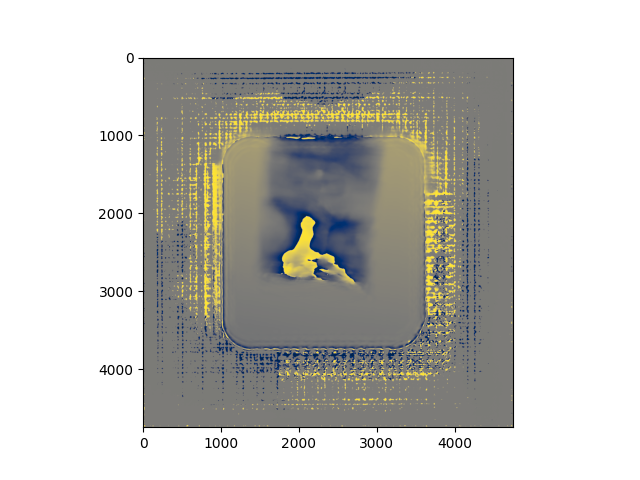

In [54]:
projections_average = np.mean(obj,axis=0)
print(obj.shape,projection.shape)

projection_ROI = np.angle(projections_average) # select abs or angle

plt.figure(dpi=100)
plt.imshow(projection_ROI)

In [ ]:
# sscCdi.deploy_visualizer(np.angle(obj),title='Original sinogram',cmap='gray')

## Crop data

In [47]:
dic["top_crop"]    = 1300 # n of pixels to remove on top
dic["bottom_crop"] = 2500 # n of pixels to remove on bottom
dic["left_crop"]   = 1200 # n of pixels to remove on left
dic["right_crop"]  = 1400 # n of pixels to remove on right

In [7]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/cropped.npy'

# cropped_data = tomo_crop(dic,obj,save=False)
cropped_data = np.load(path)

# np.save(path,cropped_data)

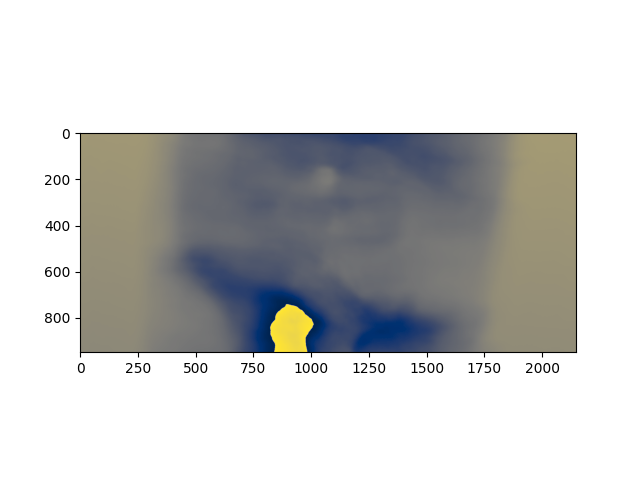

In [14]:
plt.figure()
plt.imshow(np.angle(np.mean(cropped_data,axis=0)))

In [ ]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/cropped.npy'
np.save(path,cropped_data)

## Sort data

In [6]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/sorted.npy'
path2 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles_sorted.npy'

# sorted_data, sorted_angles = tomo_sort(dic,cropped_data, angles,save=False)

# np.save(path,sorted_data)
# np.save(path2,sorted_angles)

sorted_data = np.load(path)
sorted_angles = np.load(path2)

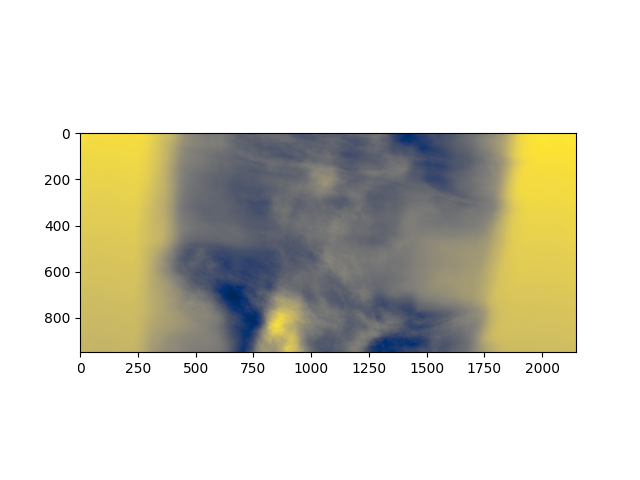

In [22]:
fig, ax = plt.subplots()
ax.imshow(np.mean(np.angle(sorted_data),axis=0))

In [19]:
sscCdi.deploy_visualizer(sorted_data,type='phase',title="Ordered sinogram",cmap='gray')

## Alignment: Cross Correlation (CC) and Vertical Mass Fluctuation (VMF)

In [8]:
aligned_data_CC = alignment_variance_field(sorted_data, downscaling_factor=1,fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True, use_gradient = True)

Finding shift between neighboor slices...
Finding shift between slices #0/550
Finding shift between slices #50/550
Finding shift between slices #100/550
Finding shift between slices #150/550
Finding shift between slices #200/550
Finding shift between slices #250/550
Finding shift between slices #300/550
Finding shift between slices #350/550
Finding shift between slices #400/550
Finding shift between slices #450/550
Finding shift between slices #500/550
Shifting slice #0/550
Shifting slice #50/550
Shifting slice #100/550
Shifting slice #150/550
Shifting slice #200/550
Shifting slice #250/550
Shifting slice #300/550
Shifting slice #350/550
Shifting slice #400/550
Shifting slice #450/550
Shifting slice #500/550


In [6]:
# sscCdi.misc.deploy_visualizer(aligned_data_CC,type='phase',title='CC',cmap='gray',axis=0) # select axis

In [7]:
# sscCdi.misc.deploy_visualizer(aligned_data_CC2,type='phase',title='CC',cmap='gray',axis=0) # select axis

In [8]:
# sscCdi.misc.deploy_visualizer(aligned_data_CC3,type='phase',title='CC',cmap='gray',axis=0) # select axis

In [9]:
aligned_data_CC2 = alignment_variance_field(sorted_data, downscaling_factor=2,fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True, use_gradient = True)

Downscaling images for alignment...
Finding shift between neighboor slices...
Finding shift between slices #0/550
Finding shift between slices #50/550
Finding shift between slices #100/550
Finding shift between slices #150/550
Finding shift between slices #200/550
Finding shift between slices #250/550
Finding shift between slices #300/550
Finding shift between slices #350/550
Finding shift between slices #400/550
Finding shift between slices #450/550
Finding shift between slices #500/550
Shifting slice #0/550
Shifting slice #50/550
Shifting slice #100/550
Shifting slice #150/550
Shifting slice #200/550
Shifting slice #250/550
Shifting slice #300/550
Shifting slice #350/550
Shifting slice #400/550
Shifting slice #450/550
Shifting slice #500/550


In [7]:
aligned_data_CC3 = alignment_variance_field(sorted_data, downscaling_factor=4,fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True, use_gradient = True)

Downscaling images for alignment...
Finding shift between neighboor slices...
Finding shift between slices #0/550
Finding shift between slices #50/550
Finding shift between slices #100/550
Finding shift between slices #150/550
Finding shift between slices #200/550
Finding shift between slices #250/550
Finding shift between slices #300/550
Finding shift between slices #350/550
Finding shift between slices #400/550
Finding shift between slices #450/550
Finding shift between slices #500/550
Shifting slice #0/550
Shifting slice #50/550
Shifting slice #100/550
Shifting slice #150/550
Shifting slice #200/550
Shifting slice #250/550
Shifting slice #300/550
Shifting slice #350/550
Shifting slice #400/550
Shifting slice #450/550
Shifting slice #500/550


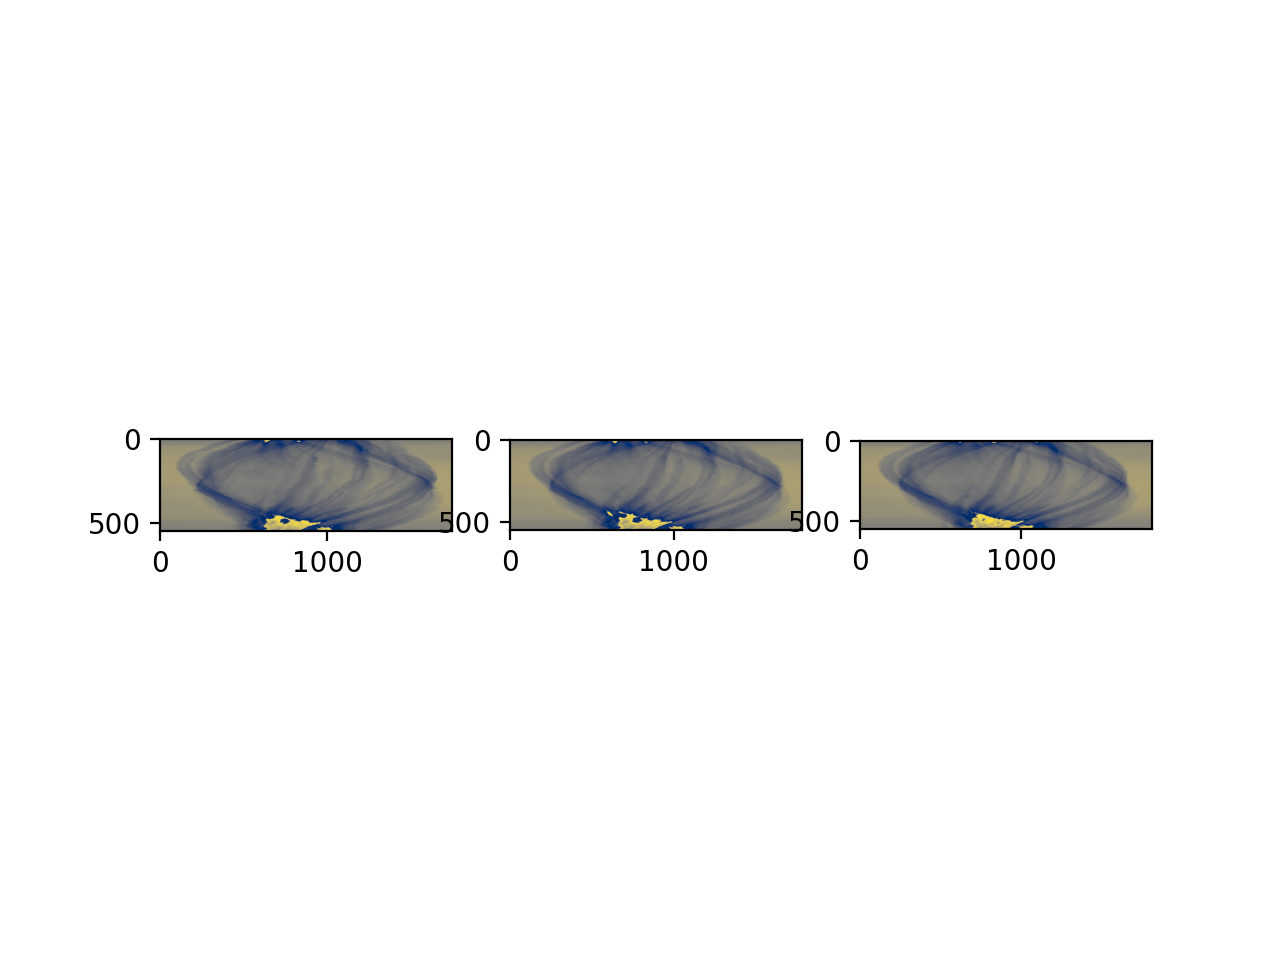

In [11]:
fig, ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(np.angle(aligned_data_CC[:,aligned_data_CC.shape[1]//2,:]))
ax[1].imshow(np.angle(aligned_data_CC2[:,aligned_data_CC2.shape[1]//2,:]))
ax[2].imshow(np.angle(aligned_data_CC3[:,aligned_data_CC3.shape[1]//2,:]))

In [10]:
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/aligned.npy'
# np.save(path,aligned_data_CC)
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/aligned2.npy'
# np.save(path,aligned_data_CC2)
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/aligned3.npy'
# np.save(path,aligned_data_CC3)

In [12]:
# aligned_data_VMF = sscCdi.alignment_vertical_mass_fluctuation(aligned_data_CC, use_phase_gradient = True, return_common_valid_region=True, remove_null_borders = True, plot = False) # if data is not equalized, phase gradient should be used

In [13]:
# sscCdi.misc.deploy_visualizer(np.angle(aligned_data_VMF),title='VMF',cmap='gray',axis=0) # select axis

In [14]:
# np.save(dic["pre_aligned_sinogram_filepath"],aligned_data_VMF) # select which prealigned dataset to save

## Unwrap

In [ ]:
from sscCdi import unwrap_in_parallel
unwrapped1 = unwrap_in_parallel(np.angle(aligned_data_CC))
unwrapped2 = unwrap_in_parallel(np.angle(aligned_data_CC2))
unwrapped3 = unwrap_in_parallel(np.angle(aligned_data_CC3))

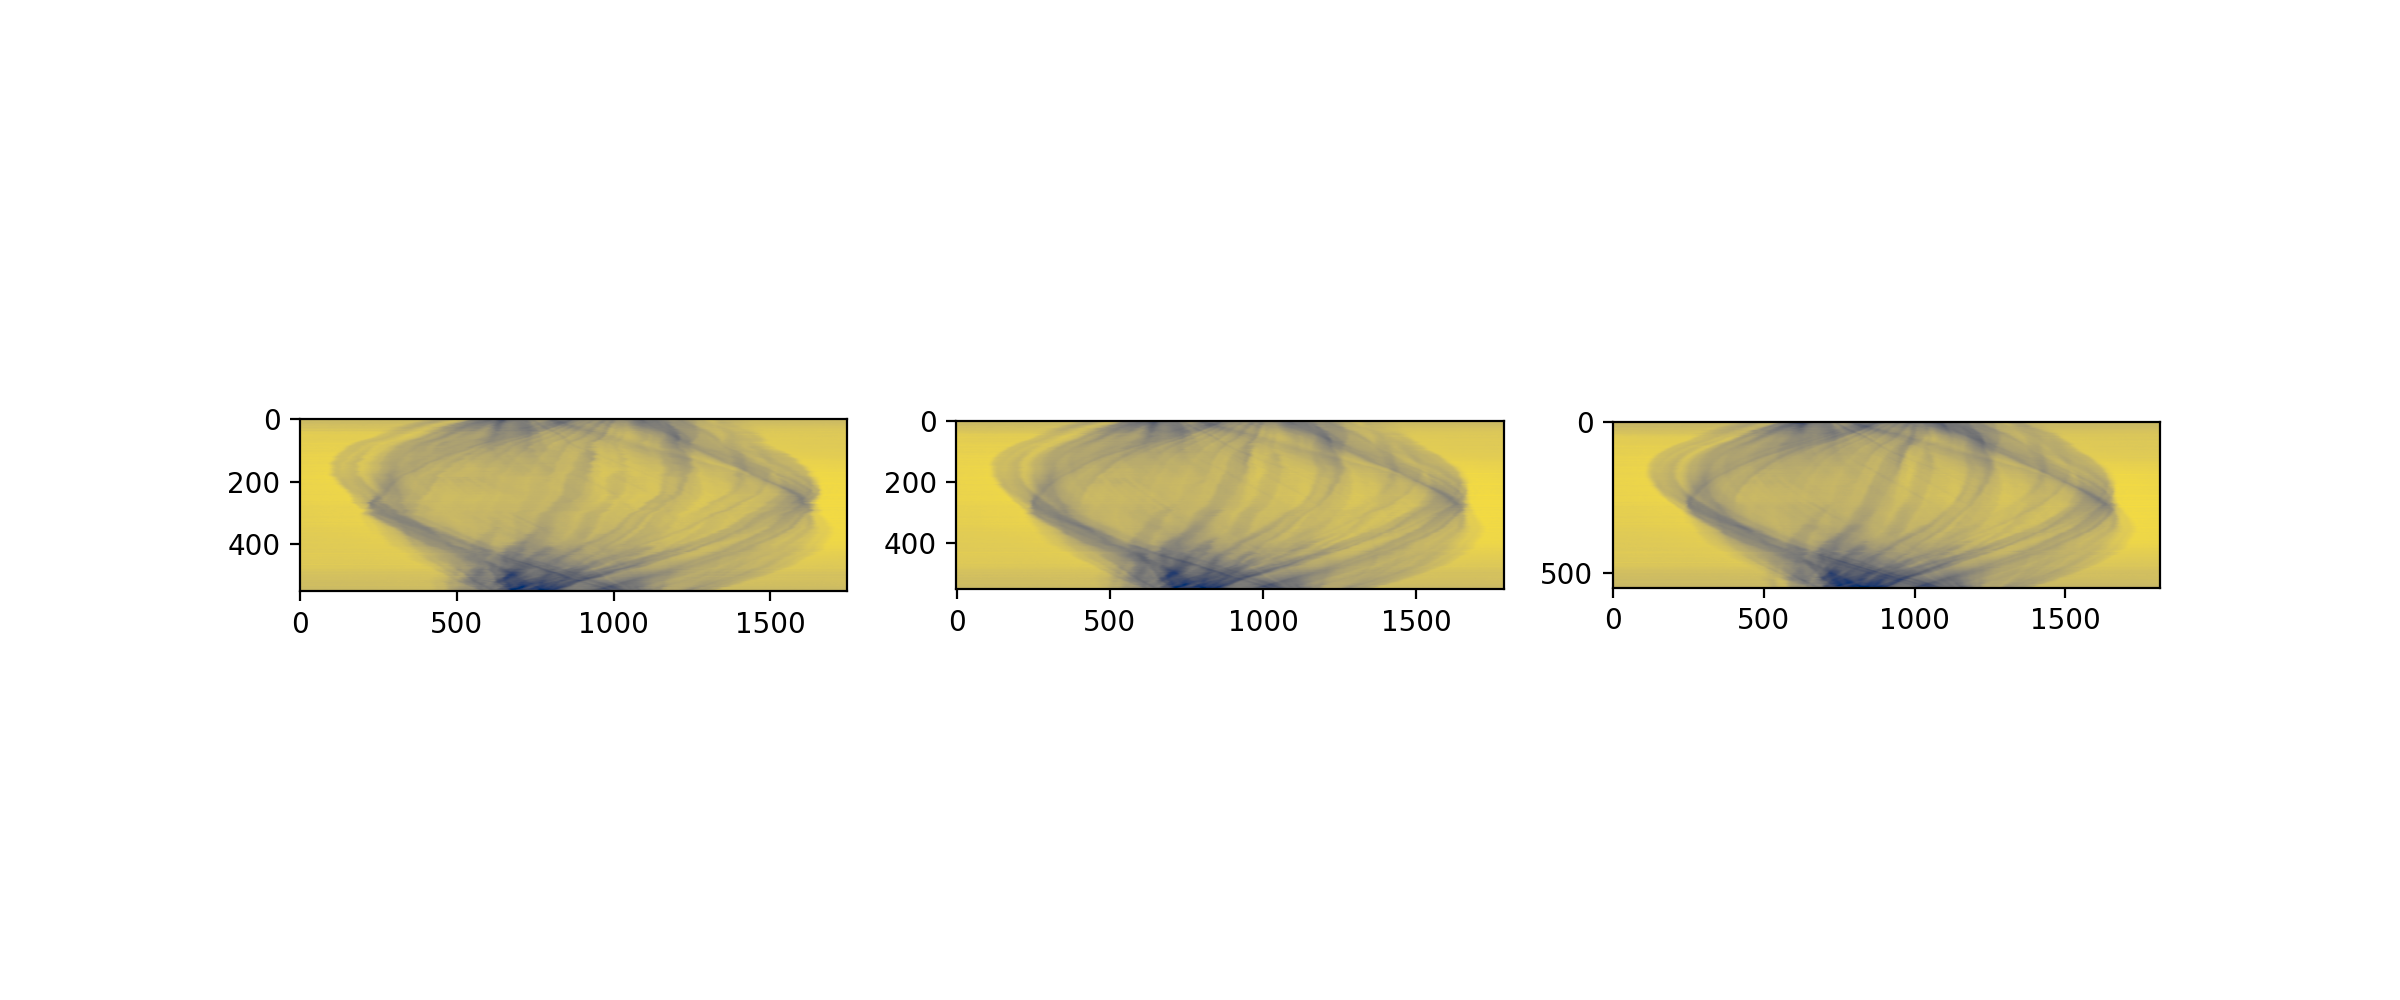

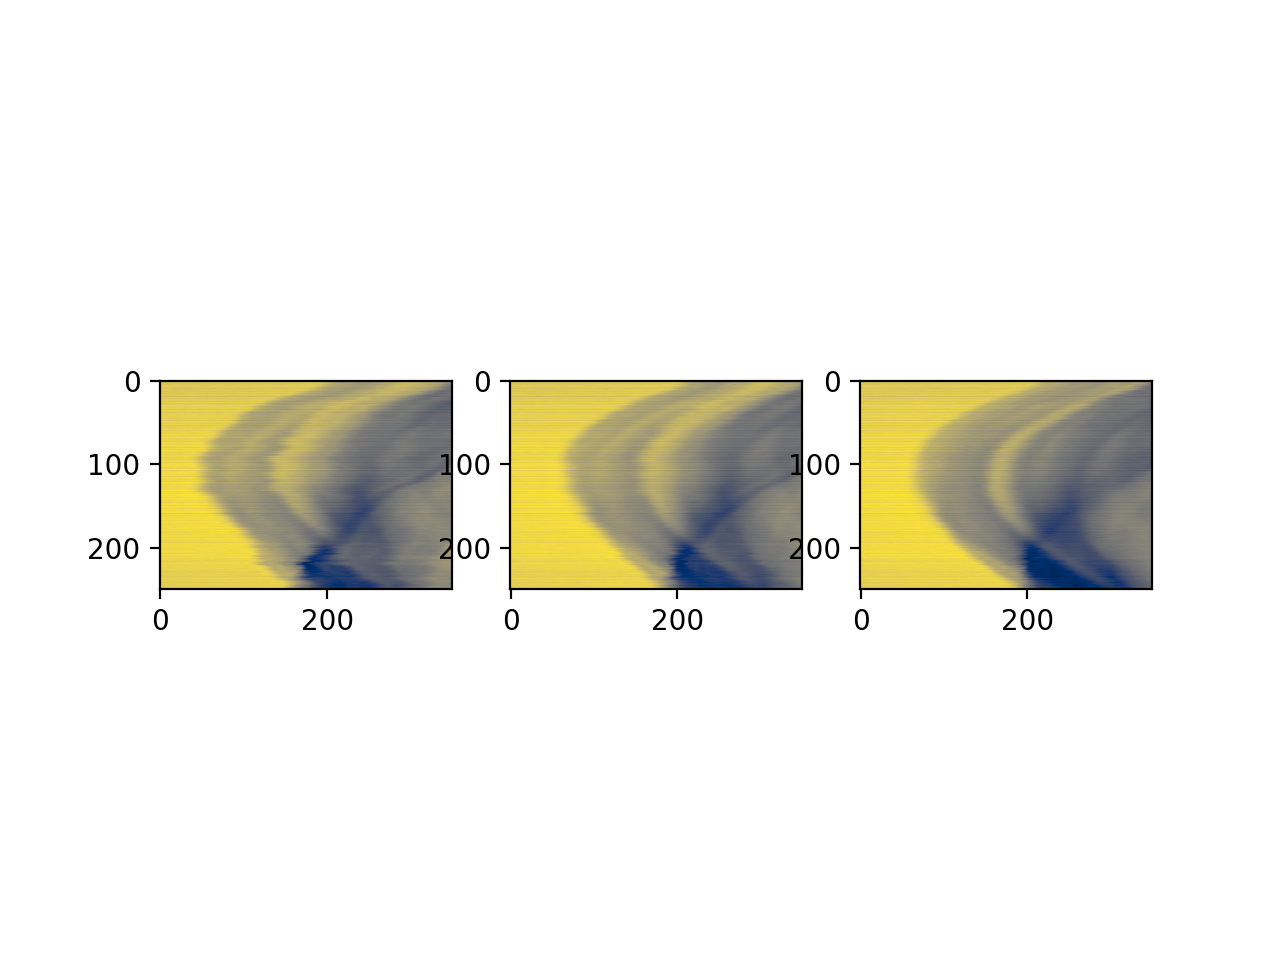

In [18]:
fig, ax = plt.subplots(1,3,figsize=(12,5),dpi=200)
ax[0].imshow(unwrapped1[:,unwrapped1.shape[1]//2,:])
ax[1].imshow(unwrapped2[:,unwrapped2.shape[1]//2,:])
ax[2].imshow(unwrapped3[:,unwrapped3.shape[1]//2,:])

fig, ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(unwrapped1[50:300,unwrapped1.shape[1]//2,50:400])
ax[1].imshow(unwrapped2[50:300,unwrapped1.shape[1]//2,50:400])
ax[2].imshow(unwrapped3[50:300,unwrapped1.shape[1]//2,50:400])

In [13]:
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/unwrapped1.npy'
# np.save(path,unwrapped1)
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/unwrapped2.npy'
# np.save(path,unwrapped2)
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/unwrapped3.npy'
# np.save(path,unwrapped3)

In [ ]:
# aligned_data_VMF = alignment_vertical_mass_fluctuation(aligned_data_CC, filter_sigma=2,curve_portion=None,use_phase_gradient = True, return_common_valid_region=False, remove_null_borders = False, plot = None)

In [24]:
sscCdi.deploy_visualizer(unwrapped3,title="Unwrapped sinogram",cmap='gray')

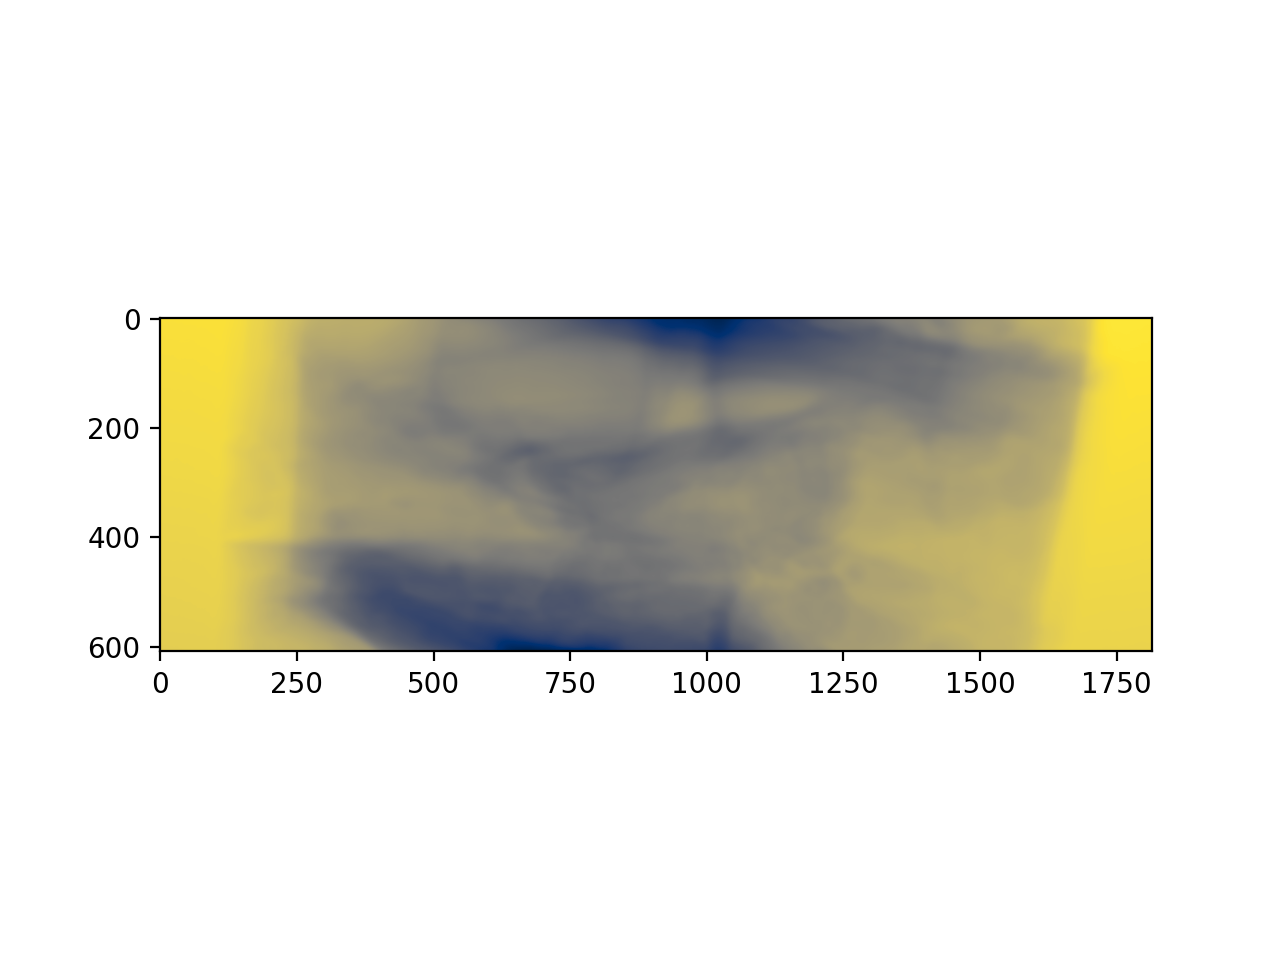

In [23]:
projection = np.mean(unwrapped3,axis=0)

fig, ax = plt.subplots(dpi=200)
ax.imshow(projection)

## 2D Equalization

In [41]:
dic={}
dic["bad_frames_before_equalization"] = []
dic["CPUs"] = 32

dic["equalize_invert"] = True # invert phase shift signal from negative to positive
# dic["equalize_ROI"] = [500,600,1750,1800] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_ROI"] = [0,600,0,40] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_remove_phase_gradient"] = False  # if empty and equalize_ROI = [], will subtract best plane fit from whole image
dic["equalize_remove_phase_gradient_iterations"] = 5
dic["equalize_local_offset"] = False # remove offset of each frame from the mean of ROI 
dic["equalize_set_min_max"]= [] # [minimum,maximum] threshold values for whole volume
dic["equalize_non_negative"] = False # turn any remaining negative values to zero


In [42]:
equalized_sinogram = tomo_equalize(dic,unwrapped3)

Sinogram shape to equalize:  (550, 609, 1815)
Using 32 parallel processes


100%|██████████| 550/550 [00:02<00:00, 191.47it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old -0.24, -4.70, 1.24, 7.19,10.33
New: -1.90, -3.12,0.54, 4.20,10.69
Time elapsed: 8.02 s


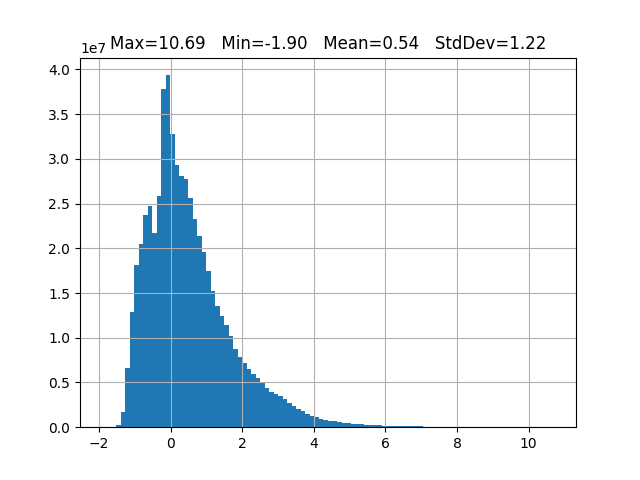

In [43]:
sscCdi.misc.plot_volume_histogram(equalized_sinogram)

In [28]:
sscCdi.deploy_visualizer(equalized_sinogram,title="Equalized sinogram",cmap='gray')

In [44]:
sscCdi.deploy_visualizer(equalized_sinogram,title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto')

In [7]:
# equalized_sinogram -= np.min(equalized_sinogram)

path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/equalized.npy'
# np.save(path,equalized_sinogram)
equalized_sinogram = np.load(path)

## Alignment (wiggle) 

In [25]:
# dic["wiggle_sinogram_selection"] = dic["equalized_sinogram_filepath"]
dic["step_percentage"] = 100 # need to project irregular angle steps to a regular grid?

In [26]:
# sscCdi.preview_angle_projection(dic)

In [53]:
dic["project_angles_to_regular_grid"] = False
# dic["bad_frames_before_wiggle"] = [] 
dic["wiggle_reference_frame"] = 0 

In [ ]:
# dic = sscCdi.tomo_alignment(dic)

In [30]:
# preview_angle_projection(dic)

In [28]:
angles  = angles*np.pi/180
object = equalized_sinogram

object, _, _, projected_angles = angle_grid_organize(object, angles,percentage=dic["step_percentage"])
dic['n_of_used_angles']     = projected_angles.shape 
# np.save(dic["projected_angles_filepath"],projected_angles)

dic['n_of_original_angles'] = angles.shape # save to output log

# tomoP, wiggle_cmas = wiggle(dic, object)

In [ ]:
sscCdi.deploy_visualizer(tomoP),title="Aligned sinogram",cmap='gray',axis=1)

## Tomography: select dictionary according to tomographic method
- for details on the tomography algorithm inputs, see documentation at https://gcc.lnls.br/wiki/docs/ssc-raft/reconstructions/

In [55]:
dic['using_wiggle'] = False
dic["project_angles_to_regular_grid"] = False

dic['automatic_regularization'] = 0 # skip if 0; regularization between 0 and 1 to enhance borders prior to recon (https://www.sciencedirect.com/science/article/pii/S2590037419300883?via%3Dihub)

# dic["algorithm_dic"] = { # if FBP: filtered back-projection
#     'algorithm': "FBP",
#     'gpu': [0],
#     'filter': 'lorentz', # 'gaussian','lorentz','cosine','rectangle'
#     'regularization': 0.1, # 0 <= regularization <= 1; use for smoothening
#     'shift center':0,
# }

dic["algorithm_dic"] = { # if eEM: emission expectation maximization
    'algorithm': "EM",
    'gpu': [0],
    'regularization': 0.1,
    'method': 'eEM', 
    'niterations': [10,0,0,0], # [global iterations, iterations EMTV, iterations2 EMTV, Cone-beam integration points]
    'epsilon': 1e-15, #for EMTV only
    'blocksize': 20, # blocks for parallelization
}

In [56]:
# # sinogram = np.load(dic["equalized_sinogram_filepath"])
# sinogram = np.load(dic["wiggle_sinogram_filepath"])

dic["ordered_angles_filepath"] = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles_sorted.npy'

recon3D2 = tomo_recon(dic,equalized_sinogram,save=False)

Starting tomographic algorithm EM algorithm
	 Tomography done!
Time elapsed: Tomography: 42.20746898651123 s


In [14]:
sscCdi.deploy_visualizer(recon3D,title="Recon",cmap='gray',axis=0)#,limits=(-1,1))

In [8]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomo_EM20.npy'
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomo_EM40.npy'
# np.save(path,recon3D2)

recon3D = np.load(path)

In [15]:
projection3D = np.sum(recon3D,axis=1)



In [9]:
path = '/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/tomo_20iter/2023-07-28-14h16m_A2_02_complex_tomo_equalized.npy'
path = '/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/retomo_40iter/2023-07-28-14h16m_A2_02_complex_tomo_equalized.npy'
recon3D2 = np.load(path)
print(recon3D2.shape)


(1844, 1729, 1729)


In [10]:
projection3D2 = np.sum(recon3D2,axis=1)


(<matplotlib.image.AxesImage at 0x7f3e3d438250>, Text(0.5, 1.0, 'Old CC '))

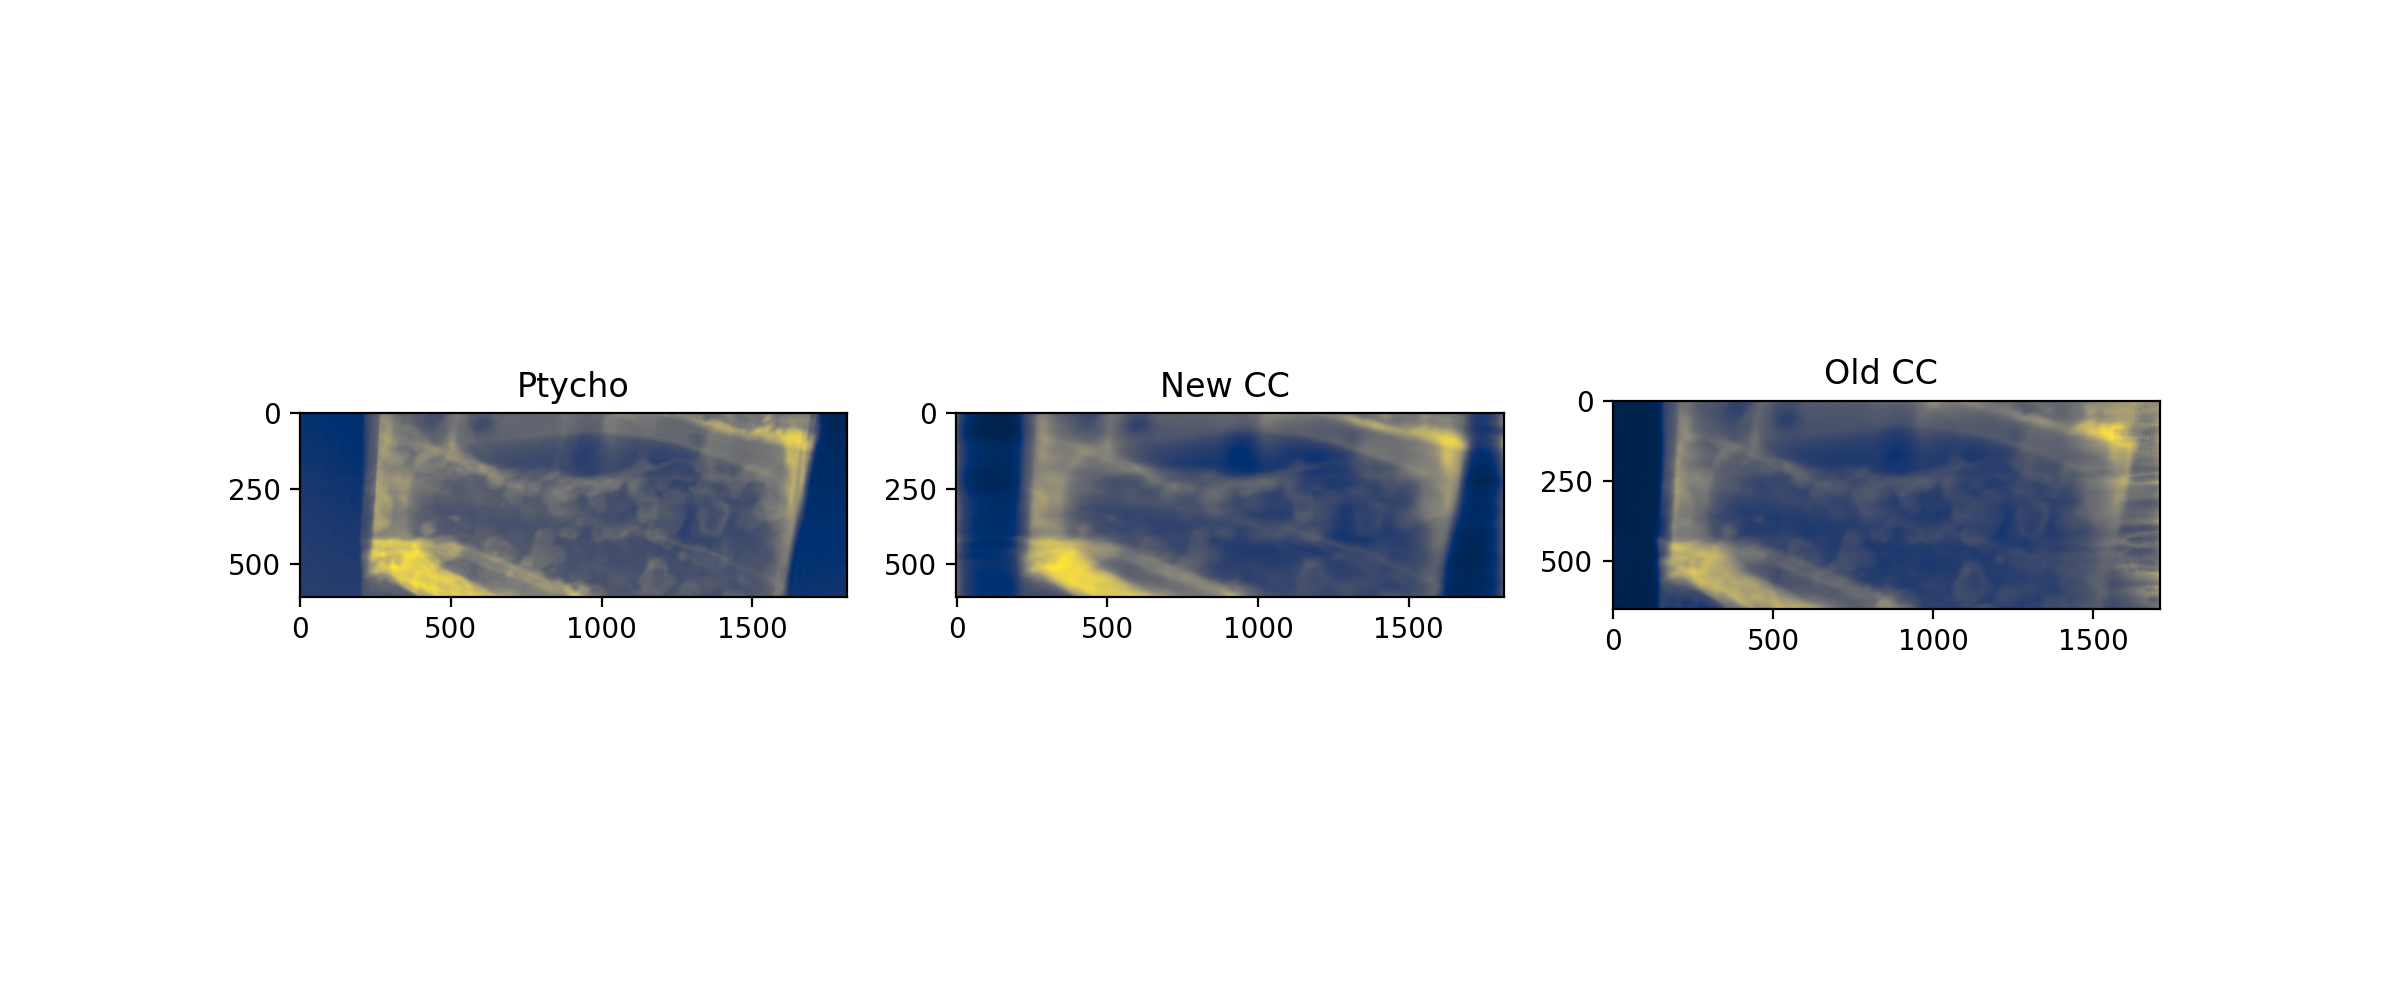

In [16]:
fig, ax = plt.subplots(1,3,figsize=(12,5),dpi=200)
ax[0].imshow(equalized_sinogram[277]), ax[0].set_title('Ptycho') 
ax[1].imshow(projection3D), ax[1].set_title('New CC ')
ax[2].imshow(projection3D2[100:750,0:-20]), ax[2].set_title('Old CC ')


In [7]:
import tomopy

In [ ]:
# aligned_tomopy, error_tomopy =  tomopy.prep.alignment.align_seq(equalized_sinogram, sorted_angles[:,1]*np.pi/180, fdir='.', iters=10, pad=(0, 0), blur=True, center=None, algorithm='gridrec', upsample_factor=10, rin=0.5, rout=0.8, save=True, debug=True)

Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
KeyboardInterrupt
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/multiprocessing/util.py", line 357, in _exit_function
    p.join()
  File "/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


In [ ]:
aligned_tomopy =  tomopy.prep.alignment.align_joint(equalized_sinogram, sorted_angles[:,1]*np.pi/180, fdir='./', iters=20, pad=(0, 0), blur=True, center=None, algorithm='sirt', upsample_factor=10, rin=0.5, rout=0.8, save=True, debug=True)

In [ ]:
aligned_tomopy[0].shape

In [ ]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomopy_seq.npy'
np.save(path,aligned_tomopy[0])
